## Vectorized Backtesting

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pathlib import Path
from time import time
import datetime 

import numpy as np 
import pandas as pd
import pandas_datareader as web

from scipy.stats import spearmanr

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
np.random.seed(42)

## Load Data
Return Predictions

In [4]:
DATA_DIR = Path('..', 'data')

In [5]:
data = pd.read_hdf('00_data/backtest.h5', 'data')
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 190201 entries, ('AAPL', Timestamp('2014-12-09 00:00:00')) to ('LNG', Timestamp('2017-11-29 00:00:00'))
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   predicted  74054 non-null   float64
 1   open       190201 non-null  float64
 2   high       190201 non-null  float64
 3   low        190201 non-null  float64
 4   close      190201 non-null  float64
 5   volume     190201 non-null  float64
dtypes: float64(6)
memory usage: 10.2+ MB


### SP500 Benchmark

In [6]:
sp500 = web.DataReader('SP500', 'fred', '2014', '2018').pct_change()

In [7]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1044 entries, 2014-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SP500   1042 non-null   float64
dtypes: float64(1)
memory usage: 16.3 KB


### Compute Forward Returns

In [8]:
daily_returns = data.open.unstack('ticker').sort_index().pct_change()
daily_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 750 entries, 2014-12-09 to 2017-11-29
Columns: 257 entries, AAPL to LNG
dtypes: float64(257)
memory usage: 1.5 MB


In [9]:
fwd_returns = daily_returns.shift(-1)

In [10]:
fwd_returns

ticker,AAPL,ABBV,ADBE,AET,AGN,AIG,ALXN,AMAT,AMD,AMGN,...,ARNC,LL,EMR,DFS,SWN,URI,RIG,SDRL,HTZ,LNG
date,,,,,,,,,,,,,,,,,,,,,
2014-12-09,0.038297,0.018033,0.003084,0.006642,0.005251,0.004907,0.015573,0.009532,0.011765,-0.007750,...,0.003769,0.010691,0.009239,0.006075,0.007931,0.004040,0.000000,0.006855,0.015531,0.023963
2014-12-10,-0.018792,-0.042627,-0.020402,-0.027063,-0.009914,-0.007596,-0.017915,-0.020115,-0.027132,-0.013609,...,-0.021902,-0.021969,-0.024148,-0.020282,-0.007527,-0.008779,-0.022334,-0.050213,-0.032710,-0.039904
2014-12-11,-0.016034,0.000752,0.058060,0.008161,-0.001386,0.000182,-0.028599,-0.009217,-0.019920,-0.021356,...,-0.039028,-0.021631,-0.023209,-0.007743,-0.014478,-0.031091,-0.036551,-0.018817,-0.028546,-0.013750
2014-12-12,0.002173,-0.011724,0.020089,0.004104,0.000771,-0.007653,-0.002387,0.007188,0.024390,0.009991,...,0.002663,0.008844,-0.024257,-0.011785,0.013991,-0.038183,-0.002964,0.010046,-0.032550,0.036755
2014-12-15,-0.039115,-0.009734,-0.036875,-0.017713,0.013487,-0.025891,-0.035627,-0.027288,-0.031746,-0.043030,...,-0.001328,0.019555,-0.011539,-0.020951,-0.040359,-0.022572,-0.036861,-0.019892,-0.001869,-0.068612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-22,0.010037,-0.007287,-0.007378,-0.001020,0.023392,-0.001679,-0.003510,-0.018493,-0.002629,-0.002119,...,0.002522,-0.022933,0.020247,-0.001066,0.000000,-0.006468,0.000000,-0.014925,-0.012994,-0.010412
2017-11-24,-0.000286,0.007340,0.010221,-0.003119,-0.008057,-0.006054,0.007138,-0.016076,-0.003515,0.006254,...,0.002935,-0.003912,-0.005808,-0.001220,0.000000,-0.004752,0.000000,0.053636,-0.010971,0.010101
2017-11-27,-0.004284,0.013201,0.004274,0.003470,-0.002880,-0.005753,-0.001289,0.001405,0.009700,0.000059,...,-0.008779,-0.018208,0.016228,-0.001069,0.000000,0.007457,0.000000,-0.089157,0.032723,-0.010000


In [11]:
fwd_returns = daily_returns.shift(-1)

### Generate Signals

In [12]:
predictions = data.predicted.unstack('ticker')
predictions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 750 entries, 2014-12-09 to 2017-04-14
Columns: 257 entries, AAPL to LNG
dtypes: float64(257)
memory usage: 1.5 MB


In [13]:
N_LONG = N_SHORT = 15

In [14]:
long_signals = ((predictions
                 .where(predictions > 0)
                 .rank(axis=1, ascending=False) > N_LONG)
                .astype(int))

short_signals = ((predictions
                 .where(predictions < 0)
                 .rank(axis=1) > N_SHORT)
                .astype(int))

In [15]:
fwd_returns

ticker,AAPL,ABBV,ADBE,AET,AGN,AIG,ALXN,AMAT,AMD,AMGN,...,ARNC,LL,EMR,DFS,SWN,URI,RIG,SDRL,HTZ,LNG
date,,,,,,,,,,,,,,,,,,,,,
2014-12-09,0.038297,0.018033,0.003084,0.006642,0.005251,0.004907,0.015573,0.009532,0.011765,-0.007750,...,0.003769,0.010691,0.009239,0.006075,0.007931,0.004040,0.000000,0.006855,0.015531,0.023963
2014-12-10,-0.018792,-0.042627,-0.020402,-0.027063,-0.009914,-0.007596,-0.017915,-0.020115,-0.027132,-0.013609,...,-0.021902,-0.021969,-0.024148,-0.020282,-0.007527,-0.008779,-0.022334,-0.050213,-0.032710,-0.039904
2014-12-11,-0.016034,0.000752,0.058060,0.008161,-0.001386,0.000182,-0.028599,-0.009217,-0.019920,-0.021356,...,-0.039028,-0.021631,-0.023209,-0.007743,-0.014478,-0.031091,-0.036551,-0.018817,-0.028546,-0.013750
2014-12-12,0.002173,-0.011724,0.020089,0.004104,0.000771,-0.007653,-0.002387,0.007188,0.024390,0.009991,...,0.002663,0.008844,-0.024257,-0.011785,0.013991,-0.038183,-0.002964,0.010046,-0.032550,0.036755
2014-12-15,-0.039115,-0.009734,-0.036875,-0.017713,0.013487,-0.025891,-0.035627,-0.027288,-0.031746,-0.043030,...,-0.001328,0.019555,-0.011539,-0.020951,-0.040359,-0.022572,-0.036861,-0.019892,-0.001869,-0.068612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-22,0.010037,-0.007287,-0.007378,-0.001020,0.023392,-0.001679,-0.003510,-0.018493,-0.002629,-0.002119,...,0.002522,-0.022933,0.020247,-0.001066,0.000000,-0.006468,0.000000,-0.014925,-0.012994,-0.010412
2017-11-24,-0.000286,0.007340,0.010221,-0.003119,-0.008057,-0.006054,0.007138,-0.016076,-0.003515,0.006254,...,0.002935,-0.003912,-0.005808,-0.001220,0.000000,-0.004752,0.000000,0.053636,-0.010971,0.010101
2017-11-27,-0.004284,0.013201,0.004274,0.003470,-0.002880,-0.005753,-0.001289,0.001405,0.009700,0.000059,...,-0.008779,-0.018208,0.016228,-0.001069,0.000000,0.007457,0.000000,-0.089157,0.032723,-0.010000


In [17]:
long_returns = long_signals.mul(fwd_returns).mean(axis=1)
short_returns = short_signals.mul(-fwd_returns).mean(axis=1)
strategy = long_returns.add(short_returns).to_frame('strategy')

### Plot results

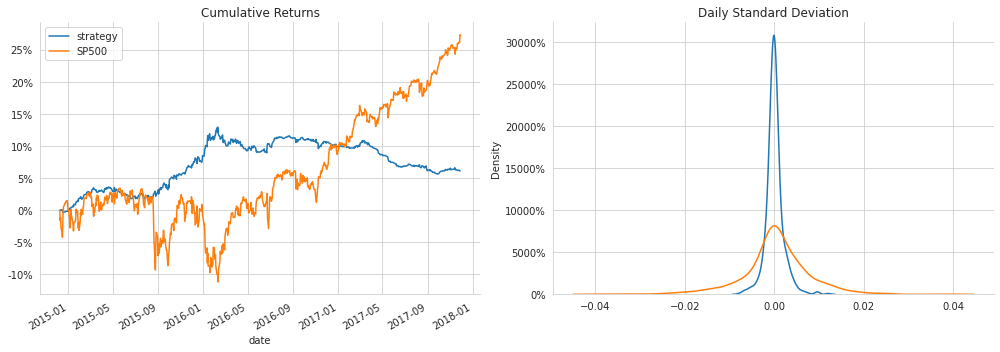

In [37]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
strategy.join(sp500).add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Returns')
sns.distplot(strategy.dropna(), ax=axes[1], hist=False, label='Strategy')
sns.distplot(sp500.dropna(), ax=axes[1], hist=False, label='SP500')
axes[1].set_title('Daily Standard Deviation')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _ : f'{y:.0%}'))
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _ : f'{y:.0%}'))
sns.despine()
fig.tight_layout()

In [33]:
res = strategy.join(sp500).dropna()

In [34]:
res.std()

strategy    0.001980
SP500       0.007928
dtype: float64

In [35]:
res.corr()

,strategy,SP500
strategy,1.0000,-0.1017
SP500,-0.1017,1.0000
